In [306]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# import lazypredict

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

In [307]:
df_ger = pd.read_csv('Data/USA.csv',  index_col='Year')
df_ger # the one with categorical variable for Germany

,Country,ISO 3166-1 alpha-3,Total,Coal,Oil,Gas
Year,,,,,,
1980,USA,USA,4808.520356,1453.794000,2244.444000,1058.054000
1981,USA,USA,4686.369198,1502.932000,2101.611000,1032.089000
1982,USA,USA,4447.255938,1449.085000,1994.450000,960.901000
1983,USA,USA,4429.374051,1504.796000,1978.053000,901.094000
1984,USA,USA,4662.141491,1616.103000,2034.520000,962.252000
1985,USA,USA,4652.579989,1655.025000,2023.815000,926.516000
1986,USA,USA,4663.369645,1635.733000,2112.065000,867.866000
1987,USA,USA,4825.650651,1709.484000,2143.098000,922.972000
1988,USA,USA,5050.475381,1792.727000,2241.115000,964.373000


In [308]:
# Drop the categorial variables
df= df_ger.select_dtypes(include=['float64'])
df

,Total,Coal,Oil,Gas
Year,,,,
1980,4808.520356,1453.794000,2244.444000,1058.054000
1981,4686.369198,1502.932000,2101.611000,1032.089000
1982,4447.255938,1449.085000,1994.450000,960.901000
1983,4429.374051,1504.796000,1978.053000,901.094000
1984,4662.141491,1616.103000,2034.520000,962.252000
1985,4652.579989,1655.025000,2023.815000,926.516000
1986,4663.369645,1635.733000,2112.065000,867.866000
1987,4825.650651,1709.484000,2143.098000,922.972000
1988,5050.475381,1792.727000,2241.115000,964.373000


In [309]:
#  plot to see total emission versus year for 'Germany'
fig_ger = px.line(df, x=df.index, y="Total")
fig_ger.update_xaxes(rangeslider_visible=True)
fig_ger.show()

Visualize the time series

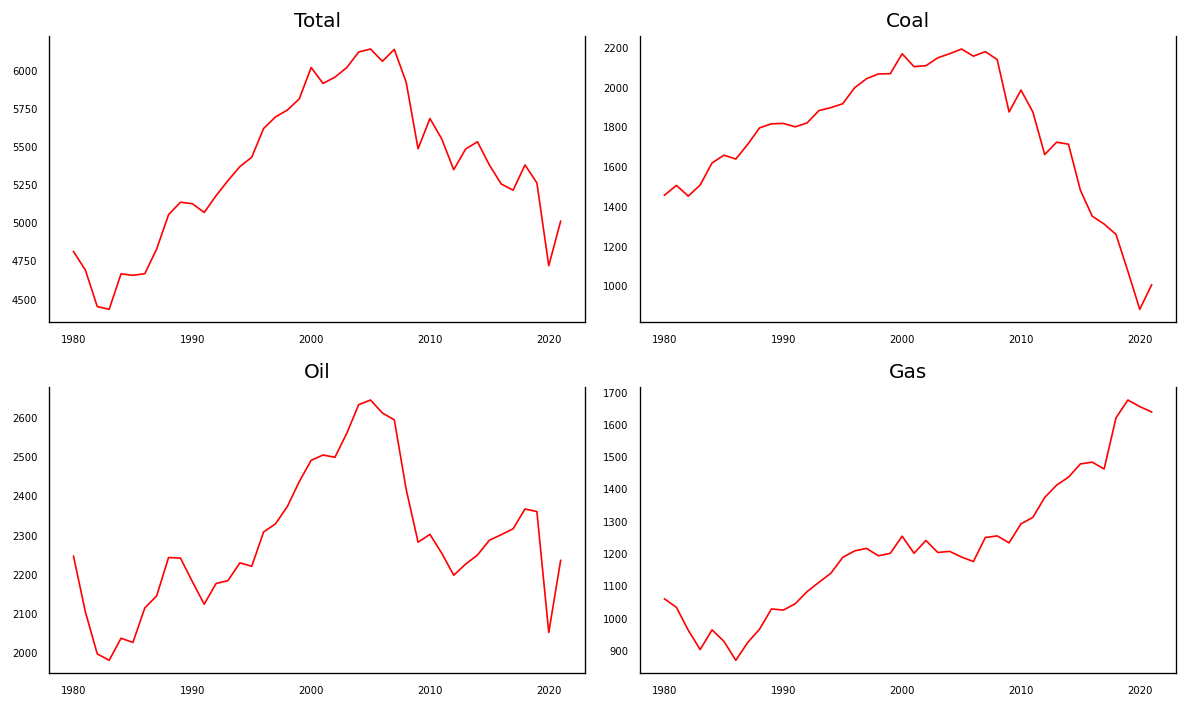

In [310]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

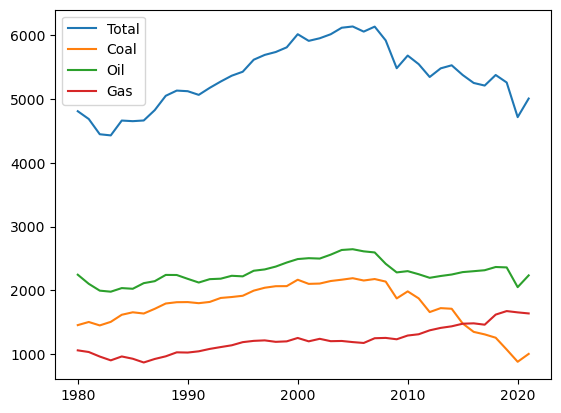

In [311]:
plt.figure()

x = df.index
y1 = df['Total']
y2 = df['Coal']
y3 = df['Oil']
y4 = df['Gas']






plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)




plt.legend(['Total', 'Coal', 'Oil', 'Gas'])

Grainger's Causality Test

In [312]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)   

,Total_x,Coal_x,Oil_x,Gas_x
Total_y,1.0,0.0,0.0,0.0
Coal_y,0.0,1.0,0.0,0.0
Oil_y,0.0,0.0,1.0,0.0
Gas_y,0.0,0.0,0.0,1.0


 Cointegration Test

In [313]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Total  ::  102.28    > 40.1749   =>   True
Coal   ::  53.72     > 24.2761   =>   True
Oil    ::  22.47     > 12.3212   =>   True
Gas    ::  4.8       > 4.1296    =>   True
